<a href="https://colab.research.google.com/github/lizhieffe/language_model/blob/main/Stable_Diffusion_v3_v2_%2B_better_U_Net_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Follow the instruction: https://tree.rocks/make-diffusion-model-from-scratch-easy-way-to-implement-quick-diffusion-model-e60d18fd0f2e

TODO
- better way to add noise
- better way to write U-Net
- add positional embeddings
- see more in https://www.youtube.com/watch?v=a4Yfz2FxXiY&list=WL&index=90

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

import re

from typing import Dict, List

import numpy as np

!pip install tqdm
from tqdm.auto import trange, tqdm

In [2]:
USE_GPU = True

# number of workers in .map() call
# good number to use is ~order number of cpu cores // 2
#
# However, use 24 causes the Dataloader to fail.
NUM_PROC = 2

In [3]:
BATCH_SIZE = 32  # for training batch size
IMG_SIZE = 64     # input image size, CIFAR-10 is 32x32

In [4]:
if USE_GPU:
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  assert device.type != 'cpu', "GPU is not available"
else:
  device = 'cpu'

print(device)

cuda:0


# Load dataset

- CIFAR-10

In [5]:
import torchvision
import torchvision.transforms as transforms

In [6]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize(size=(IMG_SIZE,IMG_SIZE), antialias=True), # (h, w)
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Note: when `download`==False, it needs to mount the folder with the downloaded
# training data to the env (e.g. colab docker).

trainset = torchvision.datasets.FGVCAircraft(root='/home/training_data/', split='train',
                                             download=False, transform=transform)
testset = torchvision.datasets.FGVCAircraft(root='/home/training_data/', split='val',
                                             download=False, transform=transform)

# If the dataset is not previously downloaded and mounted, use these two lines
# below instead to download them.

# trainset = torchvision.datasets.FGVCAircraft(root='./data', split='val',
                                            #  download=True, transform=transform)
# trainset = torchvision.datasets.FGVCAircraft(root='./data', split='test',
#                                              download=True, transform=transform)

In [7]:
len(trainset)

3334

In [8]:
# The ordering of labels is:

classes = ('plane', 'car', 'bird', 'cat',
            'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [9]:
def _get_car_subset(ds: torch.utils.data.Dataset) -> torch.utils.data.Dataset:
  """
  Extract the sub dataset containing the image corresponding to label 'car'.
  """
  idx = [i for i, (image, label) in enumerate(ds) if label == 1]
  # print(f'{len(idx)=}')
  sub_ds = torch.utils.data.Subset(ds, idx)
  return sub_ds

In [10]:
trainloader = torch.utils.data.DataLoader(_get_car_subset(trainset),
                                          batch_size=BATCH_SIZE,
                                          shuffle=True,
                                          num_workers=NUM_PROC,
                                          drop_last=True)

testloader = trainloader

# testloader = torch.utils.data.DataLoader(_get_car_subset(testset),
#                                           batch_size=BATCH_SIZE,
#                                           shuffle=True,
#                                           num_workers=NUM_PROC, drop_last=True)

In [11]:
len(trainset)

3334

In [12]:
print(f'train ds size = {len(trainloader)}, test_ds size = {len(testloader)}')

train ds size = 1, test_ds size = 1


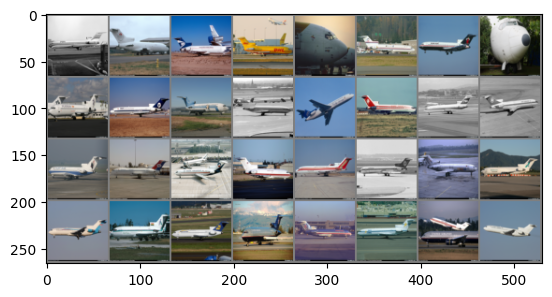

In [13]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:32]))
# print labels
# print(' '.join(f'{classes[labels[j]]:5s}' for j in range(BATCH_SIZE)))


# Function for preview data

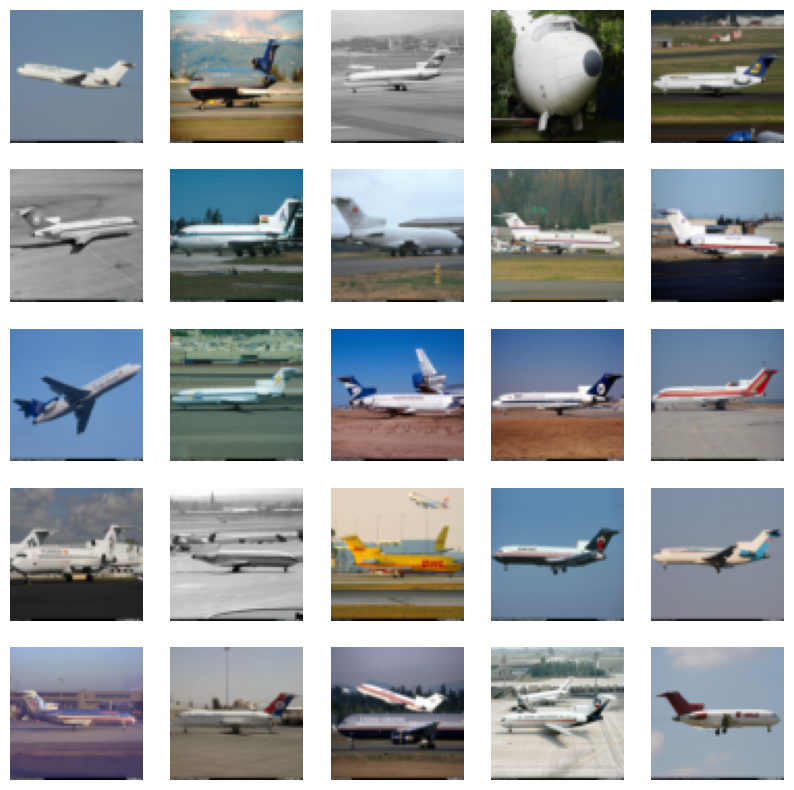

In [14]:
def cvtImg(img: torch.Tensor) -> List:
  """Convert the image to be used in `imshow`.

  The image in data has float in range [-1, 1].

  Convert it to [0, 1] range.

  Args
    img: (B, C, W, T)

  Return
    A list with B size, containing Tensors of shape (C, W, T).
  """
  img = img.permute(0, 2, 3, 1)   # (B, 3, IMG_SIZE, IMG_SIZE) ---> (B, IMG_SIZE, IMG_SIZE, 3)
  img = img - img.min()
  img = (img / img.max())
  return img.cpu().numpy().astype(np.float32)

def show_examples(x: torch.Tensor):
  """Display 25 images.

  Args
    x: a batch of images. (B, C, W, H)
  """
  plt.figure(figsize=(10, 10))
  # x = torch.clamp(x, min=-1.0, max=1.0)
  imgs = cvtImg(x)
  for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(imgs[i])
    plt.axis('off')

images, _ = next(iter(trainloader))
show_examples(images)

# Noise

- timestamp 0: most noisy
- timestamp 16: most clear

In [15]:
timesteps = 16    # how many steps for a noisy image into clear
time_bar = 1 - np.linspace(0, 1.0, timesteps + 1)

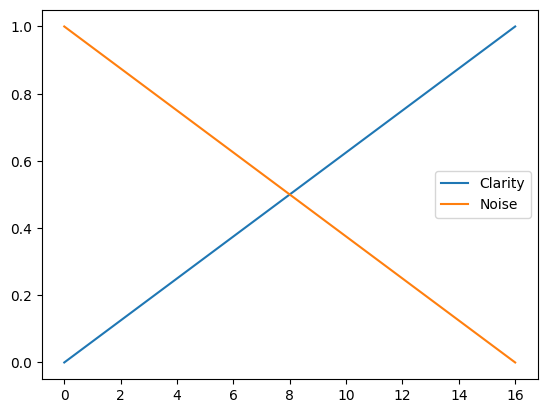

In [16]:
plt.plot(1 - time_bar, label='Clarity')
plt.plot(time_bar, label='Noise')
plt.legend()

In [17]:
def generate_ts(num: int) -> List[int]:
  """Generate random timesteps.

  Returns:
    The result contains `num` timesteps, each in range [0, timesteps 15).

  """
  return np.random.randint(0, timesteps, size=num)

def forward_noise(x: torch.Tensor, t: List[int]):
  """Add noise to images.

  For each image, it generates two images, the img_from is at the leading
  timestep, the img_to is at the next timestep.

  Note that x and t both have B as the leading dim; the x is noisified to mimic
  the noise at the leading and next timesteps at the corresponding indices of t.

  Args
    x: the images. (B, 3, IMG_SIZE, IMG_SIZE)
    t: a list of leading timesteps. (B)

  Return
    imgs_from: the noisified images to mimic the noise at the leading timesteps.
      (B, 3, IMG_SIZE, IMG_SIZE)
    imgs_to: the noisified images to mimic the noise at the next timestemps.
      (B, 3, IMG_SIZE, IMG_SIZE)
  """

  x = x.to(device)

  assert x.shape[0] == len(t)

  a = time_bar[t]       # (B)
  b = time_bar[t + 1]   # (B)
  # print(f'{a=}')
  # print(f'{b=}')

  noise = torch.normal(mean=torch.zeros_like(x),
                       std=torch.ones_like(x)).to(device)    # (3, IMG_SIZE, IMG_SIZE)
  a = torch.Tensor(a).view(-1, 1, 1, 1).to(device)        # (B, 1, 1, 1)
  b = torch.Tensor(b).view(-1, 1, 1, 1).to(device)        # (B, 1, 1, 1)
  # print(f'{a=}')
  # print(f'{b=}')

  # The clamps are needed because the added noise may get the pixel's value out
  # of [-1.0, 1.0]
  imgs_from = (1 - a) * x + a * noise                     # (B, 32, 32, 32)
  # imgs_from = torch.clamp(imgs_from, min=-1.0, max=1.0)

  imgs_to = (1 - b) * x + b * noise                       # (B, 32, 32, 32)
  # imgs_to = torch.clamp(imgs_to, min=-1.0, max=1.0)

  return imgs_from, imgs_to

t = generate_ts(25)
# Get a batch of images
x, _ = next(iter(trainloader))
imgs_from, imgs_to = forward_noise(x[:25], t)
print(f'{imgs_from.max()=}, {imgs_from.min()=}')

imgs_from.max()=tensor(4.1697, device='cuda:0'), imgs_from.min()=tensor(-3.5492, device='cuda:0')


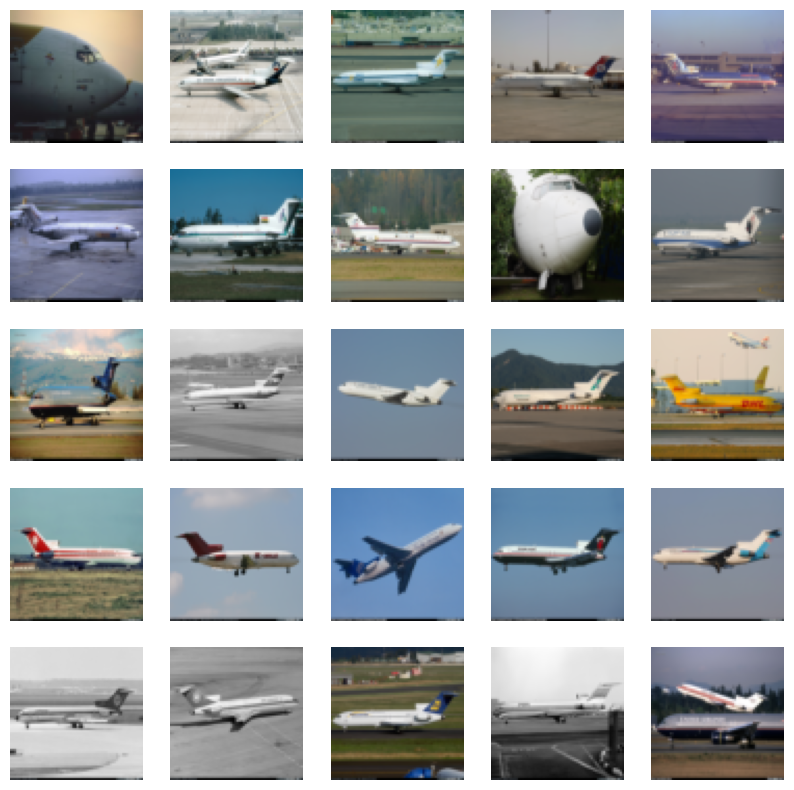

In [18]:
show_examples(x[:25])

In [19]:
# The larger it is expected to be clearer
t

array([ 7, 14, 11,  6,  5, 13,  4,  6,  3,  5, 13, 12, 10, 15,  2,  5,  5,
        7, 13,  4,  9,  7,  9,  2,  7])

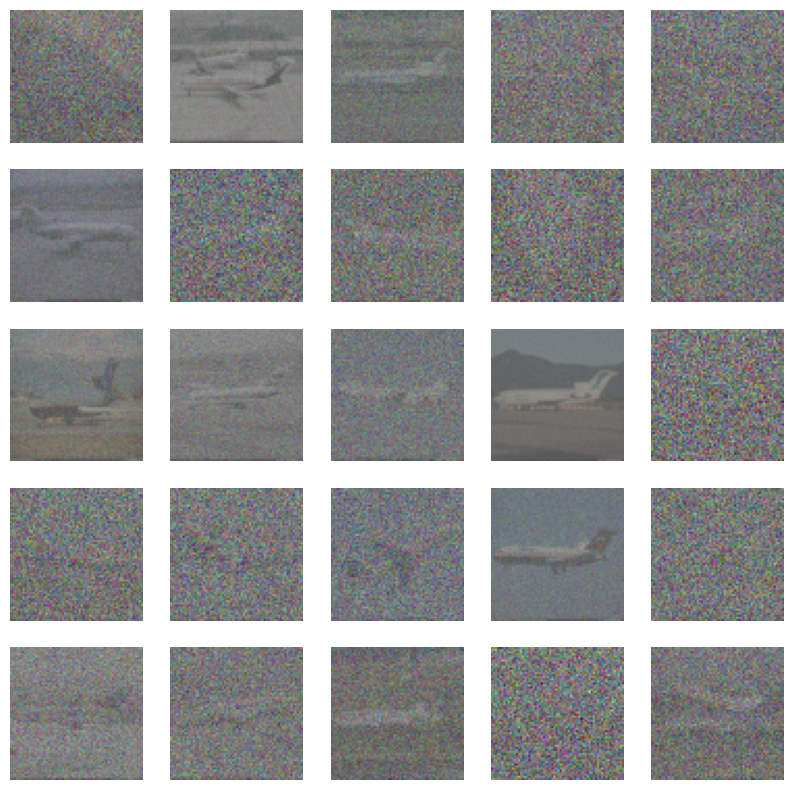

In [20]:
show_examples(imgs_from)

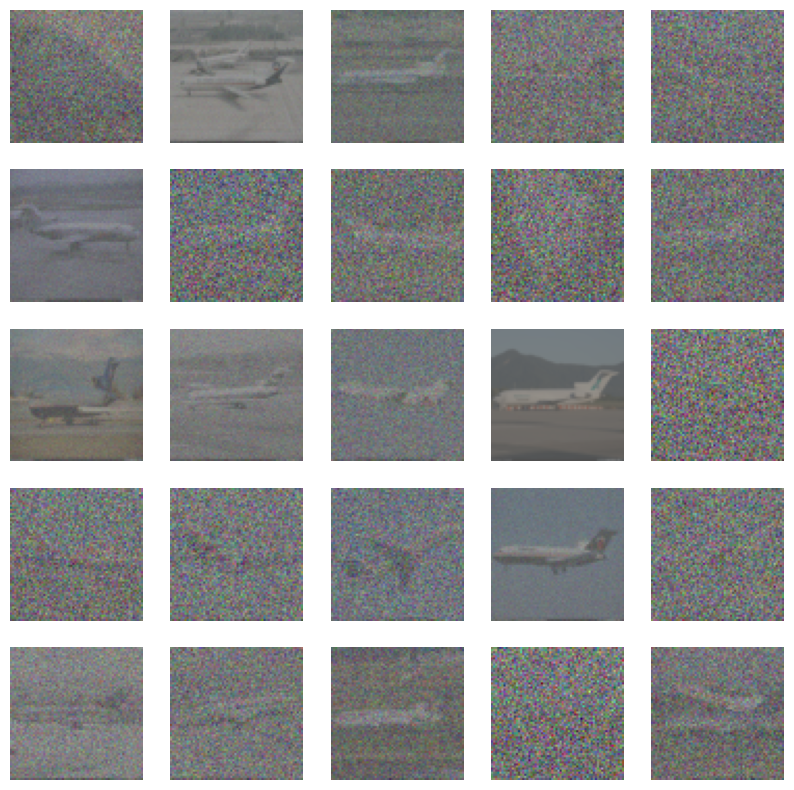

In [21]:
show_examples(imgs_to)

# Model

## Block

Each block contains two CNN with a time parameter, allowing the network to determine its current time step and output corresponding information.

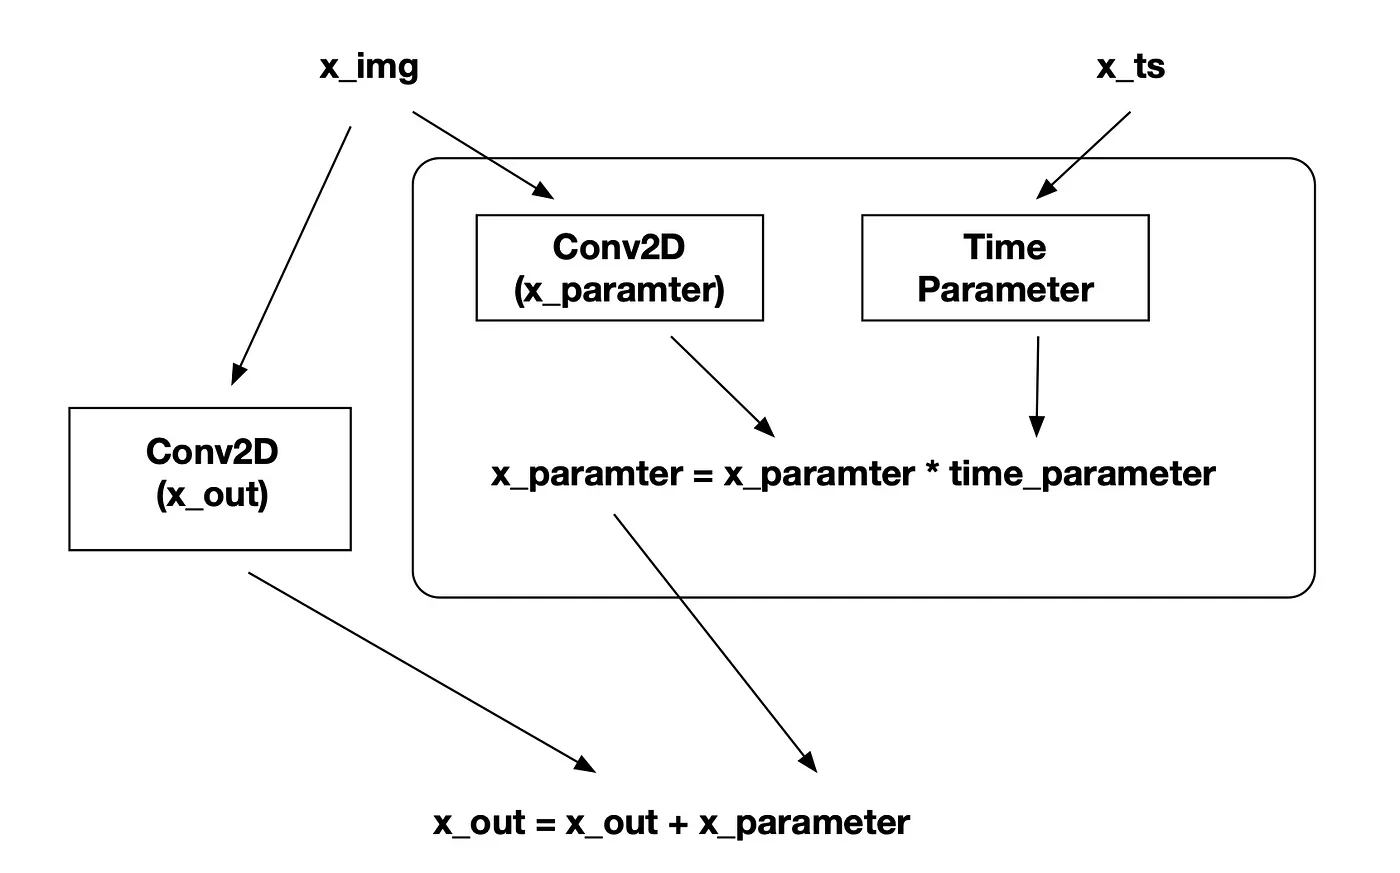

In [22]:
class Block(torch.nn.Module):
  def __init__(self, in_ch: int, out_ch: int, time_emb_dim: int, up: bool = False):
    """
    Args
      in_ch: input channel #.
      out_ch: output channel #.
      time_emb_d: dim of the time embedding.
      up: up or down block in the u-net structure.
    """
    super().__init__()
    self.time_mlp = torch.nn.Linear(time_emb_dim, out_ch)
    if up:
      self.conv1 = torch.nn.Conv2d(in_channels=2*in_ch, # 2*in_ch because the input is concatenated from the previous block and the corresponding down block
                                   out_channels=out_ch,
                                   kernel_size=3,
                                   padding=1)
      # Transform in up increase the H,W by 2x
      self.transform = torch.nn.ConvTranspose2d(in_channels=out_ch,
                                                out_channels=out_ch,
                                                kernel_size=4,
                                                stride=2,
                                                padding=1)
    else:
      self.conv1 = torch.nn.Conv2d(in_channels=in_ch,
                                   out_channels=out_ch,
                                   kernel_size=3,
                                   padding=1)
      # Transform in down reduce the H,W by 2x
      self.transform = torch.nn.Conv2d(in_channels=out_ch,
                                       out_channels=out_ch,
                                       kernel_size=4,
                                       stride=2,
                                       padding=1)
    self.conv2 = torch.nn.Conv2d(in_channels=out_ch,
                                 out_channels=out_ch,
                                 kernel_size=3,
                                 padding=1)
    self.bn1 = torch.nn.BatchNorm2d(num_features=out_ch)
    self.bn2 = torch.nn.BatchNorm2d(num_features=out_ch)

  def forward(self, x: torch.Tensor, t: torch.Tensor):
    """
    Args
      x: (B, in_ch, H, W)
      t: (B, time_emb_dim)
    """
    # First conv
    h = self.conv1(x)   # (B, out_ch, H, W)
    h = F.relu(h)    # (B, out_ch, H, W)
    h = self.bn1(h)     # (B, out_ch, H, W)

    # Time embedding
    time_emb = self.time_mlp(t)   # (B, out_ch)
    time_emb = F.relu(time_emb)   # (B, out_ch)
    # TODO: this is different compared to the instruction
    time_emb = time_emb.view(time_emb.shape[0], time_emb.shape[1], 1, 1)  # (B, out_ch, 1, 1)

    # Add time channel
    h = h + time_emb    # (B, out_ch, H, W)
    h = self.conv2(h)   # (B, out_ch, H, W)
    h = F.relu(h)       # (B, out_ch, H, W)
    h = self.bn2(h)     # (B, out_ch, H, W)

    # Down or upsample
    out = self.transform(h)    # down: (B, out_ch, H/2, W/2), up: (B, out_ch, H*2, W*2)
    # print(f'{h.shape=}, {out.shape=}')
    return out

In [23]:
# Test `Block` for Down
print(f'{x.shape=}')
block = Block(in_ch=3, out_ch=128, time_emb_dim=192, up=False)
_ = block(x, torch.ones((BATCH_SIZE, 192,)))

x.shape=torch.Size([32, 3, 64, 64])


In [24]:
# Test `Block` for Up
print(f'{x.shape=}')
block = Block(in_ch=3, out_ch=128, time_emb_dim=192, up=True)
_ = block(torch.concat([x, x], dim=1), torch.ones((BATCH_SIZE, 192,)))

x.shape=torch.Size([32, 3, 64, 64])


## U-net

In [25]:
class SimpleUnet(torch.nn.Module):
  def __init__(self):
    super().__init__()

    image_ch = 3
    # From top to down
    down_channels = (128, 128, 128, 128, 128)
    # From down to top
    up_channels = (128, 128, 128, 128, 128)
    out_d = 3
    time_emb_dim = 32

    # Time embedding
    #
    # TODO: change to better time embedding
    self.ts_emb = torch.nn.Sequential(
        torch.nn.Linear(1, time_emb_dim),
        torch.nn.ReLU()
    )

    # Initial projection
    self.conv0 = torch.nn.Conv2d(in_channels=image_ch,
                                 out_channels=down_channels[0],
                                 kernel_size=3,
                                 padding=1)

    # Downsample
    self.downs = torch.nn.ModuleList([
        Block(in_ch=down_channels[i],
              out_ch=down_channels[i+1],
              time_emb_dim=time_emb_dim,
              up=False) for i in range(len(down_channels)-1)
    ])

    # Upsample
    self.ups = torch.nn.ModuleList([
        Block(in_ch=up_channels[i],
              out_ch=up_channels[i+1],
              time_emb_dim=time_emb_dim,
              up=True) for i in range(len(up_channels)-1)
    ])

    self.conv_out = torch.nn.Conv2d(in_channels=up_channels[-1],
                                    out_channels=out_d,
                                    kernel_size=1)

  def forward(self, x: torch.Tensor, t: torch.Tensor):
    # Embed time
    t = self.ts_emb(t)  # (B, time_emb_dim)

    # Initial conv
    x = self.conv0(x)   # (B, down_channels[0], H, W)
    # print(f'000 {x.shape=}')

    # U-net
    residual_inputs = []
    for down in self.downs:
      x = down(x, t)    # (B, down_channels[i+1], H/2**(i+1), W/2**(i+1))
      residual_inputs.append(x)
      # print(f'111 {x.shape=}')

    for up in self.ups:
      residual_x = residual_inputs.pop()
      x = torch.cat([x, residual_x], dim=1) # (B, 2*down_channels[i+1], H/2**(4-i), W/2**(4-i))
      # print(f'222 {x.shape=}')
      x = up(x, t)

    ret = self.conv_out(x)  # (B, out_d, H, W)

    return ret



In [26]:
class Block1(torch.nn.Module):
  def __init__(self, in_channels: int, size: int):
    """
    Args
      in_channels: the # of input channels
      n_axis_pixels: the # of pixels on each axis
    """
    super().__init__()

    self.conv_x_param = torch.nn.Conv2d(in_channels=in_channels,
                                        out_channels=128,
                                        kernel_size=3,
                                        padding='same')
    self.conv_out = torch.nn.Conv2d(in_channels=in_channels,
                                        out_channels=128,
                                        kernel_size=3,
                                        padding='same')

    self.linear_ts_param = torch.nn.Linear(192, 128)
    self.relu_ts_param = torch.nn.ReLU()

    self.layer_norm = torch.nn.LayerNorm([128, size, size])

  def forward(self, x_img: torch.Tensor, x_ts: torch.Tensor):
    """
    Arg
      x_img: the image. (B, C, IMG_SIZE, IMG_SIZE)
      x_ts: the timestep encoding. (B, 192)
    """

    # print(f'{x_img.shape=}')
    x_param = F.relu(self.conv_x_param(x_img))    # (B, 128, IMG_SIZE, IMG_SIZE)
    # print(f'{x_param.shape=}')

    ts_param = self.relu_ts_param(self.linear_ts_param(x_ts)) # (B, 128)
    ts_param = ts_param.view(-1, 128, 1, 1)             # (B, 128, 1, 1)
    # print(f'{ts_param.shape=}')
    # print(f'{x_param.shape=}, {ts_param.shape=}')
    x_param = x_param * ts_param

    x_out = self.conv_out(x_img)            # (B, 128, size, size)
    x_out = x_out + x_param                 # (B, 128, size, size)
    x_out = F.relu(self.layer_norm(x_out))  # (B, 128, size, size)

    return x_out


print(f'{x.shape=}')
block = Block1(in_channels=3, size=IMG_SIZE)
_ = block(x, torch.ones((BATCH_SIZE, 192,)))

x.shape=torch.Size([32, 3, 64, 64])


In [27]:
class Model(torch.nn.Module):
  def __init__(self, size: int):
    """
    Args
      size: # of pixels on each direction
    """

    super().__init__()

    assert size % 8 == 0

    # self.down_x32 = Block(in_ch=3, out_ch=128, time_emb_dim=192, up=False)
    self.down_x16 = Block(in_ch=128, out_ch=128, time_emb_dim=192, up=False)
    self.down_x8 = Block(in_ch=128, out_ch=128, time_emb_dim=192, up=False)
    self.down_x4 = Block(in_ch=128, out_ch=128, time_emb_dim=192, up=False)
    self.down_x32 = Block1(in_channels=3, size=int(size))
    # self.down_x16 = Block(in_channels=128, size=int(size / 2))
    # self.down_x8 = Block(in_channels=128, size=int(size / 4))
    # self.down_x4 = Block(in_channels=128, size=int(size / 8))

    self.up_x4 = Block(in_ch=int((128+32)/2), out_ch=128, time_emb_dim=192, up=True)
    self.up_x8 = Block(in_ch=128, out_ch=128, time_emb_dim=192, up=True)
    self.up_x16 = Block(in_ch=128, out_ch=128, time_emb_dim=192, up=True)
    # self.up_x32 = Block(in_ch=256, out_ch=128, time_emb_dim=192, up=True)
    # self.up_x4 = Block(in_channels=128 + 32, size=int(size / 8))
    # self.up_x8 = Block(in_channels=256, size=int(size / 4))
    # self.up_x16 = Block(in_channels=256, size=int(size / 2))
    self.up_x32 = Block1(in_channels=256, size=int(size))

    ts_emb_dim = 192

    self.ts_emb = torch.nn.Linear(1, ts_emb_dim)

    self.mlp = torch.nn.Sequential(
        torch.nn.Linear(int(128 * (size / 8) * (size / 8)) + ts_emb_dim, 128),
        torch.nn.LayerNorm([128]),
        torch.nn.ReLU(),

        torch.nn.Linear(128,int(32 * (size / 8) * (size / 8))),
        torch.nn.LayerNorm([int(32 * (size / 8) * (size / 8))]),
        torch.nn.ReLU(),
    )

    self.cnn_output = torch.nn.Conv2d(in_channels=128,
                                      out_channels=3,
                                      kernel_size=1,
                                      padding='same')

  def forward(self, x_img: torch.Tensor, x_ts: torch.Tensor):
    """
    Args
      x_img: (B, 3, 32, 32)
      x_ts: (B, 1)
    """
    # print(f'===lizhi 0000')
    y_ts = self.ts_emb(x_ts)    # (B, 192)

    y32 = self.down_x32(x_img, y_ts)    # (B, 128, 32, 32)

    # y16 = F.max_pool2d(y32, 2)            # (B, 128, 16, 16)
    y16=y32
    y16 = self.down_x16(y16, y_ts)        # (B, 128, 16, 16)

    # y8 = F.max_pool2d(y16, 2)            # (B, 128, 8, 8)
    y8 = y16
    y8 = self.down_x8(y8, y_ts)         # (B, 128, 8, 8)
    # print(f'{y8.shape=}')

    # print(f'===lizhi 4444')
    # y4 = F.max_pool2d(y8, 2)            # (B, 128, 4, 4)
    y4 = y8
    y4 = self.down_x4(y4, y_ts)         # (B, 128, 4, 4)
    # print(f'{y4.shape=}')

    # print(f'===lizhi 6666')
    y_mlp = y4.view(y4.shape[0], -1)                          # (B, 128*4*4=2048)
    y_mlp = torch.concat([y_mlp, y_ts], dim=1)                # (B, 2048+192=2240)
    # print(f'===lizhi 7777')
    y_mlp = self.mlp(y_mlp)
    # print(f'===lizhi 8888')                                 # (B, 512)
    y_mlp = y_mlp.view(y_mlp.shape[0], -1, y4.shape[-2], y4.shape[-1])  # (B, 32, 4, 4)
    # print(f'===lizhi 9999')
    # print(f'{y_mlp.shape=}, {y4.shape=}')

    y4_up = self.up_x4(torch.cat([y4, y_mlp], dim=1), y_ts)   # (B, 128, 4, 4)

    # print(f'===lizhi 0000')
    # y8_up = F.interpolate(y4_up, scale_factor=2, mode='bilinear')   # (B, 128, 8, 8)
    y8_up = y4_up
    y8_up = self.up_x8(torch.cat([y8_up, y8], dim=1), y_ts)         # (B, 128, 8, 8)

    # y16_up = F.interpolate(y8_up, scale_factor=2, mode='bilinear')    # (B, 128, 16, 16)
    y16_up = y8_up
    y16_up = self.up_x16(torch.cat([y16_up, y16], dim=1), y_ts)       # (B, 128, 16, 16)

    # y32_up = F.interpolate(y16_up, scale_factor=2, mode='bilinear')     # (B, 128, 32, 32)
    y32_up = y16_up
    y32_up = self.up_x32(torch.cat([y32_up, y32], dim=1), y_ts)         # (B, 128, 32, 32)

    y_out = self.cnn_output(y32_up)   # (B, 3, 32, 32)

    return y_out

In [28]:
# from torch import nn
# import math


# class Block(nn.Module):
#     def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
#         super().__init__()
#         self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
#         if up:
#             self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
#             self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
#         else:
#             self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
#             self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
#         self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
#         self.bnorm1 = nn.BatchNorm2d(out_ch)
#         self.bnorm2 = nn.BatchNorm2d(out_ch)
#         self.relu  = nn.ReLU()

#     def forward(self, x, t, ):
#         # First Conv
#         h = self.bnorm1(self.relu(self.conv1(x)))
#         # Time embedding
#         time_emb = self.relu(self.time_mlp(t))
#         # Extend last 2 dimensions
#         time_emb = time_emb[(..., ) + (None, ) * 2]
#         # Add time channel
#         h = h + time_emb
#         # Second Conv
#         h = self.bnorm2(self.relu(self.conv2(h)))
#         # Down or Upsample
#         return self.transform(h)


# class SinusoidalPositionEmbeddings(nn.Module):
#     def __init__(self, dim):
#         super().__init__()
#         self.dim = dim

#     def forward(self, time):
#         device = time.device
#         half_dim = self.dim // 2
#         embeddings = math.log(10000) / (half_dim - 1)
#         embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
#         embeddings = time[:, None] * embeddings[None, :]
#         embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
#         # TODO: Double check the ordering here
#         return embeddings


# class SimpleUnet(nn.Module):
#     """
#     A simplified variant of the Unet architecture.
#     """
#     def __init__(self):
#         super().__init__()
#         image_channels = 3
#         down_channels = (64, 128, 256, 512, 1024)
#         up_channels = (1024, 512, 256, 128, 64)
#         out_dim = 3
#         time_emb_dim = 32

#         # Time embedding
#         self.time_mlp = nn.Sequential(
#                 SinusoidalPositionEmbeddings(time_emb_dim),
#                 nn.Linear(time_emb_dim, time_emb_dim),
#                 nn.ReLU()
#             )

#         # Initial projection
#         self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

#         # Downsample
#         self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
#                                     time_emb_dim) \
#                     for i in range(len(down_channels)-1)])
#         # Upsample
#         self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
#                                         time_emb_dim, up=True) \
#                     for i in range(len(up_channels)-1)])

#         # Edit: Corrected a bug found by Jakub C (see YouTube comment)
#         self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

#     def forward(self, x, timestep):
#         # Embedd time
#         timestep = timestep.view(-1)
#         # print(f'{timestep.shape=}')
#         t = self.time_mlp(timestep)
#         # Initial conv
#         x = self.conv0(x)
#         # Unet
#         residual_inputs = []
#         for down in self.downs:
#             x = down(x, t)
#             residual_inputs.append(x)
#         for up in self.ups:
#             residual_x = residual_inputs.pop()
#             # Add residual x as additional channels
#             x = torch.cat((x, residual_x), dim=1)
#             x = up(x, t)
#         return self.output(x)

# model = SimpleUnet()
# print("Num params: ", sum(p.numel() for p in model.parameters()))
# model

In [29]:
model = Model(size=IMG_SIZE).to(device)

with torch.no_grad():
  y = model(x.to(device), torch.ones(BATCH_SIZE, 1).to(device), )

x.dtype

torch.float32

In [30]:
_total_params = 0

for p in model.parameters():
  _total_params += p.nelement()

print(f'Total params = {_total_params}')

Total params = 7914115


# Optimizer

In [31]:
import torch.optim as optim

# optimizer = optim.SGD(bert.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=0.0008)

# Training

In [32]:
def get_batch(x: torch.Tensor):
  """Get a batch of training data.

  Args
    dataloader: the container of the dataset.
  """
  # print(f'{x=}')
  # Generate timestpes
  # t = generate_ts(x.shape[0])
  t = generate_ts(x.shape[0])

  imgs_from, imgs_to = forward_noise(x, t)
  ts = torch.Tensor(t).view(-1, 1).to(device)
  # ts = torch.Tensor(time_bar[t]).view(-1, 1).to(device)
  # print(f'{ts.shape=}')

  return imgs_from, ts, imgs_to

test_x, _ = next(iter(trainloader))
imgs_from, t, imgs_to = get_batch(x)

print(f'{imgs_from.shape=}, {t.shape=}, {imgs_to.shape=}')
print(f'{imgs_from.dtype=}, {t.dtype=}, {imgs_to.dtype=}')

imgs_from.shape=torch.Size([32, 3, 64, 64]), t.shape=torch.Size([32, 1]), imgs_to.shape=torch.Size([32, 3, 64, 64])
imgs_from.dtype=torch.float32, t.dtype=torch.float32, imgs_to.dtype=torch.float32


In [33]:
max_epoches = 500
n_repeats_per_epoch = 50

lossi = []
lossi_dev = []
running_loss_steps = 0
running_loss = 0.0
running_loss_dev = 0.0

log_every_n_steps = 10

max_steps = max_epoches * n_repeats_per_epoch * len(trainloader)

i = 0

for epoch in range(max_epoches):
  for n_repeat in range(n_repeats_per_epoch):
    for j, (x_img, _) in enumerate(trainloader):
      optimizer.zero_grad()

      # Forward
      Xtr, Ttr, Ytr = get_batch(x_img)
      pred_tr = model(Xtr, Ttr)

      # Loss
      # loss = F.mse_loss(pred_tr, Ytr)
      loss = torch.mean(torch.abs(pred_tr - Ytr))
      # detach() to make sure the computation graph is not kept after appending.
      lossi.append(loss.log10().detach().item())
      running_loss += loss.detach().item()

      # TODO: test if this helps
      # del Xtr, Ttr, Ytr, pred_tr

      # # Dev set
      # Xdev, Tdev, Ydev = get_batch(testloader)
      # pred_dev = model(Xdev, Tdev)
      # # loss_dev = F.mse_loss(pred_dev, Ydev)
      # loss_dev = torch.mean(torch.abs(pred_dev - Ydev))

      # lossi_dev.append(loss_dev.log10().item())
      # running_loss_dev += loss_dev.item()

      # Backward
      loss.backward()
      optimizer.step()

      running_loss_steps += 1


      if i % log_every_n_steps == 0:
        print(f'{i} / {max_steps}: loss={running_loss / running_loss_steps}, dev loss={running_loss_dev / running_loss_steps}')
        running_loss_steps = 0
        running_loss = 0.0
        running_loss_dev = 0.0

      i += 1

  # Reduce learning rate after each epoch
  for pg in optimizer.param_groups:
    pg['lr'] = max(0.000001, pg['lr'] * 0.99)
    print(f"updated lr to {pg['lr']}")

0 / 25000: loss=0.5822980403900146, dev loss=0.0
10 / 25000: loss=0.3557556107640266, dev loss=0.0
20 / 25000: loss=0.16999982446432113, dev loss=0.0
30 / 25000: loss=0.11627393290400505, dev loss=0.0
40 / 25000: loss=0.08646409139037133, dev loss=0.0
updated lr to 0.0007920000000000001
50 / 25000: loss=0.07287896350026131, dev loss=0.0
60 / 25000: loss=0.06446622386574745, dev loss=0.0
70 / 25000: loss=0.061213713511824606, dev loss=0.0
80 / 25000: loss=0.05673971176147461, dev loss=0.0
90 / 25000: loss=0.054746002331376074, dev loss=0.0
updated lr to 0.00078408
100 / 25000: loss=0.05300433151423931, dev loss=0.0
110 / 25000: loss=0.04825190976262093, dev loss=0.0
120 / 25000: loss=0.04555365294218063, dev loss=0.0
130 / 25000: loss=0.04335001930594444, dev loss=0.0
140 / 25000: loss=0.0529674306511879, dev loss=0.0
updated lr to 0.0007762392
150 / 25000: loss=0.04999258369207382, dev loss=0.0
160 / 25000: loss=0.04269692674279213, dev loss=0.0
170 / 25000: loss=0.039833135157823565, 

In [34]:
for pg in optimizer.param_groups:
  print(f"lr = {pg['lr']}")

lr = 5.256386433931685e-06


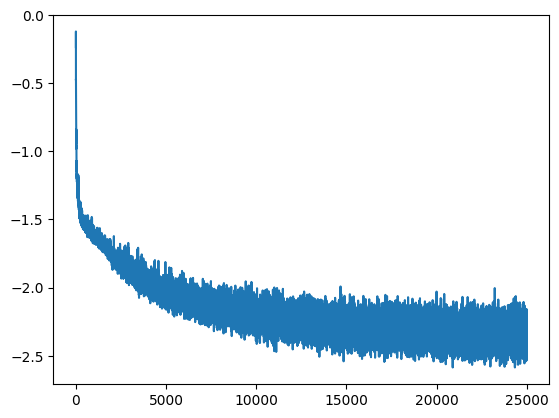

In [35]:
plt.plot(lossi)

x_img.max()=tensor(3.6989, device='cuda:0'), x_img.min()=tensor(-3.6463, device='cuda:0')
x_ts=tensor([[0.]], device='cuda:0')
x_ts=tensor([[1.]], device='cuda:0')
x_ts=tensor([[2.]], device='cuda:0')
x_ts=tensor([[3.]], device='cuda:0')
x_ts=tensor([[4.]], device='cuda:0')
x_ts=tensor([[5.]], device='cuda:0')
x_ts=tensor([[6.]], device='cuda:0')
x_ts=tensor([[7.]], device='cuda:0')
x_ts=tensor([[8.]], device='cuda:0')
x_ts=tensor([[9.]], device='cuda:0')
x_ts=tensor([[10.]], device='cuda:0')
x_ts=tensor([[11.]], device='cuda:0')
x_ts=tensor([[12.]], device='cuda:0')
x_ts=tensor([[13.]], device='cuda:0')
x_ts=tensor([[14.]], device='cuda:0')
x_ts=tensor([[15.]], device='cuda:0')


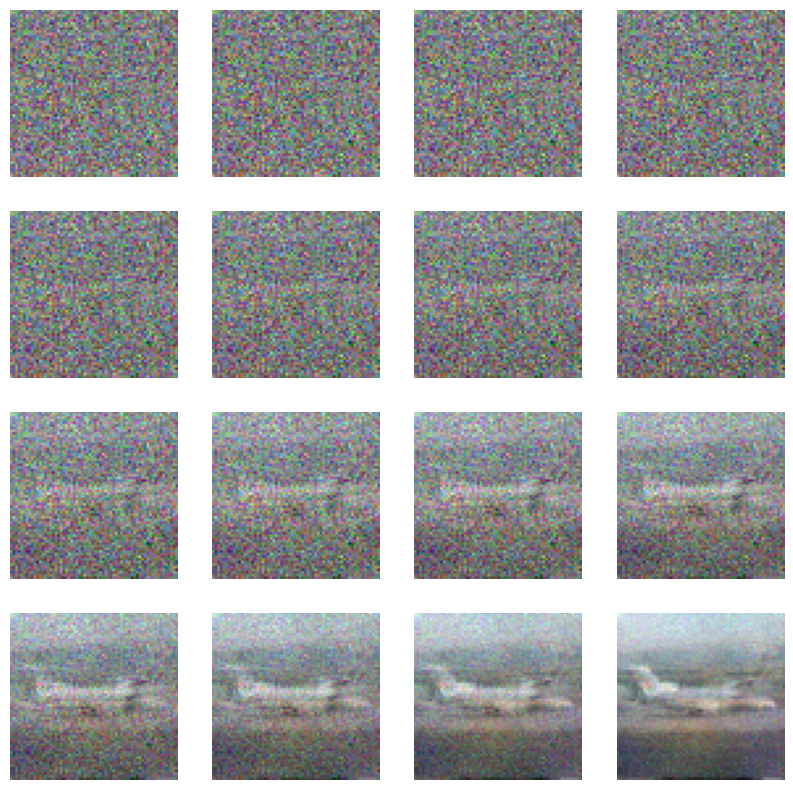

In [36]:
@torch.no_grad()
def sample(size: int):
  plt.figure(figsize=(10, 10))

  # x_img = torch.normal(mean=torch.zeros(1, 3, 32, 32),
  #                      std=torch.ones(1, 3, 32, 32)).to(device)
  x_img = torch.randn(size=(1, 3, size, size), device=device)
  print(f'{x_img.max()=}, {x_img.min()=}')
  for i in range(16):
    plt.subplot(4, 4, i+1)
    # x_show = torch.clamp(x_img, min=-1.0, max=1.0)
    plt.imshow(cvtImg(x_img.detach())[0])
    plt.axis('off')

    # x_ts = torch.Tensor([time_bar[i+1]]).view(1, 1).to(device)
    x_ts = torch.Tensor([i]).view(1, 1).to(device)
    print(f'{x_ts=}')
    x_img = model(x_img, x_ts)


sample(IMG_SIZE)


  0%|          | 0/16 [00:00<?, ?it/s]

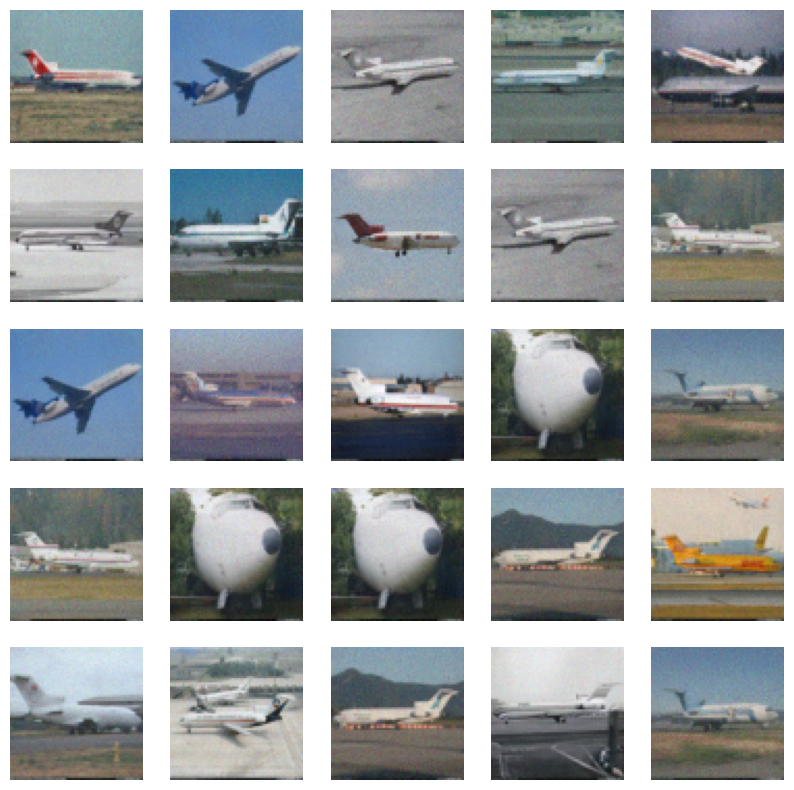

In [37]:
@torch.no_grad()
def predict(x_idx=None):
    x = torch.randn(32, 3, IMG_SIZE, IMG_SIZE).to(device)
    with torch.no_grad():
        for i in trange(timesteps):
            t = i
            x = model(x, torch.full([32, 1], t, dtype=torch.float, device=device))

    show_examples(x.cpu())

predict()

  0%|          | 0/16 [00:00<?, ?it/s]

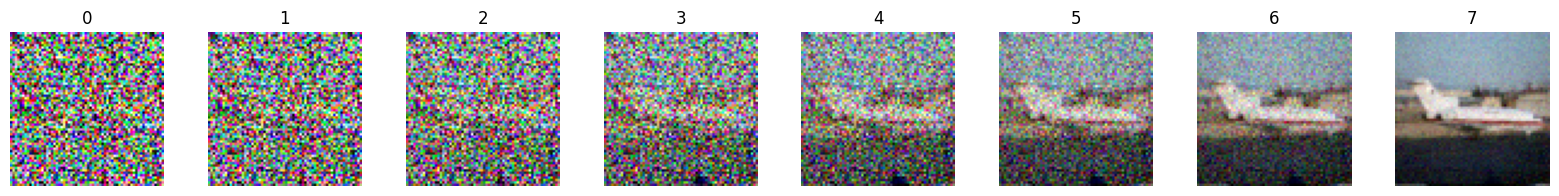

In [38]:
@torch.no_grad()
def predict_step():
    xs = []
    x = torch.randn(size=(8, 3, IMG_SIZE, IMG_SIZE), device=device)

    with torch.no_grad():
        for i in trange(timesteps):
            t = i
            x = model(x, torch.full([8, 1], t, dtype=torch.float, device=device))
            if i % 2 == 0:
                xs.append(x[0].cpu())
    xs = torch.stack(xs, dim=0)
    xs = torch.clip(xs, -1, 1)
    xs = cvtImg(xs)

    plt.figure(figsize=(20, 2))
    for i in range(len(xs)):
        plt.subplot(1, len(xs), i+1)
        plt.imshow(xs[i])
        plt.title(f'{i}')
        plt.axis('off')

predict_step()

# Author's training code

The author uses the tqdm well to print nice progress bars

In [39]:
# def train_one(x_img):
#     x_ts = generate_ts(len(x_img))
#     x_a, x_b = forward_noise(x_img, x_ts)

#     x_ts = torch.from_numpy(x_ts).view(-1, 1).float().to(device)
#     x_a = x_a.float().to(device)
#     x_b = x_b.float().to(device)

#     y_p = model(x_a, x_ts)
#     loss = torch.mean(torch.abs(y_p - x_b))
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()

#     # model.opt.zero_grad()
#     # loss.backward()
#     # model.opt.step()

#     return loss.item()

In [40]:
# def train(R=50):
#     bar = trange(R)
#     total = len(trainloader)
#     for i in bar:
#         for j, (x_img, _) in enumerate(trainloader):
#             loss = train_one(x_img)
#             pg = (j / total) * 100
#             if j % 5 == 0:
#                 bar.set_description(f'loss: {loss:.5f}, p: {pg:.2f}%')

In [41]:
# # - 30%: 0.049 loss
# for _ in range(10):
#     train()
#     # reduce learning rate for next training
#     for pg in optimizer.param_groups:
#         pg['lr'] = max(0.000001, pg['lr'] * 0.9)

#     # show result
#     predict()
#     predict_step()
#     plt.show()